In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import ast
import scipy
import mdtraj as md
from typing import Dict, Tuple
import os
from sklearn.linear_model import LinearRegression
import sys
import pyblock
bme_dir = '/projects/lindorff_group/people/thd711/HDX_project/code/BME/' # replace this with your local copy of the BME code
sys.path.append(bme_dir)
import BME as BME

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 150,                   # medium resolution

    # Axes
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def find_xtc_filenames(path_to_dir, suffix=".xtc"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

# --- Utility functions ---
def RMSE(actual, predicted):
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.sqrt(np.mean((actual - predicted)**2))

# Function to calculate helical fraction
def helical_fraction(ss_line):
    helix_chars = {'H', 'G', 'I'}
    n_residues = len(ss_line)
    n_helical = sum(1 for c in ss_line if c in helix_chars)
    return n_helical / n_residues

# Function to calculate per-residue helicity per frame
def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# functions for analysis of chemical shifts
# functions for chemical shift analysis
# Constants
# from here : https://link.springer.com/article/10.1007/s10858-010-9433-9 (average prediction error of the forward model)
CS_UNCERTAINTIES = {
    "Sparta+": {"C": 1.09, "CA": 0.94, "CB": 1.14, "N": 2.45, "H": 0.49, "HA": 0.25}
}

POTENCI_UNCERTAINTIES = {"C": 0.1861, "CA": 0.1862, "CB": 0.1677, "N": 0.5341, "H": 0.0735, "HA": 0.0319, "HB": 0.0187}

AA_dict = {
    "A": "ALA",  # Alanine
    "R": "ARG",  # Arginine
    "N": "ASN",  # Asparagine
    "D": "ASP",  # Aspartic Acid
    "C": "CYS",  # Cysteine
    "E": "GLU",  # Glutamic Acid
    "Q": "GLN",  # Glutamine
    "G": "GLY",  # Glycine
    "H": "HIS",  # Histidine
    "I": "ILE",  # Isoleucine
    "L": "LEU",  # Leucine
    "K": "LYS",  # Lysine
    "M": "MET",  # Methionine
    "F": "PHE",  # Phenylalanine
    "P": "PRO",  # Proline
    "S": "SER",  # Serine
    "T": "THR",  # Threonine
    "W": "TRP",  # Tryptophan
    "Y": "TYR",  # Tyrosine
    "V": "VAL",  # Valine
}

# atom types to use during reweighting: choose from [ HA CA HN N C CB ]
ATOM_TYPES = ["CA", "HA", "CB", "HN", "N", "C", "H"] # HN and H present because "H" is used in potenci shift tables
ATOM_TYPES = ["CA"] 

def load_experimental_shifts(path: str, ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                if col=='HN':
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append('H') # rename HN to H
                            values.append(value)
                    except:
                        continue
                else:
                    try:
                        value = float(df[col][i])
                        if value>0:
                            residues.append(res)
                            names.append(col)
                            values.append(value)
                    except:
                        continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_and_filter_experimental_shifts(path: str, bmrb_stats_path: str, sigma_cutoff = 3.0, ATOM_TYPES = ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    bmrb = pd.read_csv(bmrb_stats_path)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#RESID'][i])
        resname = str(df['RESNAME'][i])
        if len(resname)==1:
            resname = AA_dict[resname] # convert to 3-letter code if 1-letter
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        # extract bmrb avg and sd
                        if col=='HN':
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == 'H')]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append('H') # rename HN to H
                                values.append(value)
                        else:
                            row = bmrb[(bmrb["comp_id"] == resname) & (bmrb["atom_id"] == col)]
                            bmrb_mu = row["avg"].values[0]
                            bmrb_sd = row["std"].values[0]
                            if np.abs(value - bmrb_mu) < bmrb_sd * sigma_cutoff:
                                residues.append(res)
                                names.append(col)
                                values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_potenci_shifts(path: str, ATOM_TYPES = ATOM_TYPES) -> Dict[Tuple[int, str], float]:
    """Load experimental chemical shifts. Returns first column is 'resSeq', second is 'name', third is 'value'."""
    df = pd.read_csv(path, delim_whitespace=True)
    residues = []
    names = []
    values = []
    for i in range(len(df)):
        res = int(df['#NUM'][i])
        for col in df.columns[2:]:
            if col in ATOM_TYPES: # only including specified nuclei
                try:
                    value = float(df[col][i])
                    if value>0:
                        residues.append(res)
                        names.append(col)
                        values.append(value)
                except:
                    continue
            else:
                continue
    return {(int(res), str(name)): float(value) for res, name, value in zip(residues, names, values)}

def load_generated_shifts(path: str) -> pd.DataFrame:
    """
    Load generated shifts from a CSV file.
    Assumes columns: resSeq, name, 0, 1, 2, ..., representing one residue/atom per row and frames across columns.
    Returns DataFrame indexed by (resSeq, name), with frames as columns.
    """
    df = pd.read_csv(path)
    df["resSeq"] = df["resSeq"].astype(int)
    df["name"] = df["name"].astype(str)
    df.set_index(["resSeq", "name"], inplace=True)
    return df

def standardize_deltas(gen_df: pd.DataFrame, exp_dict: Dict[Tuple[int, str], float],
                       predictor: str = "Sparta+", avg_gscore: float = None) -> Tuple[np.ndarray, list]:
    cs_uncertainties = CS_UNCERTAINTIES[predictor]
    keys = sorted(set(exp_dict).intersection(set(gen_df.index)))

    if avg_gscore is None:
        std_devs = np.array([cs_uncertainties[a] for (_, a) in keys]).reshape(-1, 1)
    else:
        std_devs = np.array([
            POTENCI_UNCERTAINTIES[a] + ( cs_uncertainties[a] - POTENCI_UNCERTAINTIES[a] ) * (1 - avg_gscore)
            for r, a in keys
        ]).reshape(-1, 1)
    
    exp_vals = np.array([exp_dict[k] for k in keys]).reshape(-1, 1)
    gen_vals = gen_df.loc[keys].values  # shape: (n_obs, n_frames)
    std_delta = (gen_vals - exp_vals) / std_devs
    return std_delta, keys, exp_vals, gen_vals, std_devs

# function to calculate the difference between experiment and simulation: CALC - EXP
def raw_diff(gen_df: pd.DataFrame, exp_dict: Dict[Tuple[int, str], float]):
    keys = sorted(set(exp_dict).intersection(set(gen_df.index)))
    exp_vals = np.array([exp_dict[k] for k in keys]).reshape(-1, 1)
    gen_vals = gen_df.loc[keys].values  # shape: (n_obs, n_frames)
    diff = gen_vals - exp_vals

    return diff, keys

def get_RMSE_cs(
    std_delta_cs: np.ndarray,  # shape (n_obs, n_samples)
    weights: np.ndarray = None,  # shape (n_samples,)
    order: int = 2,  # order of the norm
) -> float:
    """Root Mean Square Error."""
    assert len(std_delta_cs.shape) == 2
    mask_nan = ~np.isnan(std_delta_cs).any(axis=0)
    if weights is None:
        return np.linalg.norm(np.average(std_delta_cs[:, mask_nan], axis=1), ord=order) / np.power(
            len(std_delta_cs),
            1 / order,
        )
    mask_nan_weights = ~np.isnan(weights)
    if weights[mask_nan_weights & (~mask_nan)].sum() != 0:
        print("+++ WARNING: samples with NaN chemical shifts should have 0 weight")
    mask_nan = mask_nan & mask_nan_weights
    if not mask_nan.any():  # this happens if the optimization failed
        return np.nan
    return np.linalg.norm(
        np.average(std_delta_cs[:, mask_nan], weights=weights[mask_nan], axis=1),
        ord=order,
    ) / np.power(len(std_delta_cs), 1 / order)

path = '../'

# SAXS functions
def parse_gensaxs_dat(filename: str):

    df = pd.read_csv(filename)
    # drop index column
    df = df.drop(columns=["Unnamed: 0"])
    q = np.array(df.columns).astype(float) # shape (n_obs, )
    I_gen = np.array(df) # shape (n_samples, n_obs)

    return q, I_gen

# function to fit saxs curves to experimental curves & calculate chi2
def fit_SAXS(I_gen, I_exp, I_exp_err):

    wlr = 1/(I_exp_err**2)

    model = LinearRegression()
    model.fit(I_gen.reshape(-1,1),I_exp,wlr)
    alpha = model.coef_[0]
    beta = model.intercept_

    scaled = alpha*I_gen+beta

    # Calculate chi^2
    N = len(I_gen)
    chi2 = ((I_exp - scaled)**2 / I_exp_err**2).sum()
    chi2red = chi2/N

    return chi2red, scaled, alpha, beta

outpath='../Ensemble_reweighting/rest2_rew_cs_saxs/'
data_path = '../Ensemble_reweighting/'


In [2]:
protein = 'ACTR_REST2_300K_ensemble'
traj_names = np.sort(find_xtc_filenames(f'./{protein}/'))

# load CS data
all_types = ['CA', 'CB', 'HA', 'C', 'HN', 'H', 'N']
for i in range(len(traj_names)):
    if i==0:
        gen_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
    else:
        tmp_df = load_generated_shifts(data_path+f'./{protein}/CS/CS_{traj_names[i][:-4]}.csv')
        gen_df= pd.concat([gen_df, tmp_df], axis=1, join = 'outer', ignore_index=True)

# experimental CS data
exp_dict = load_and_filter_experimental_shifts(data_path+f'./exp_data_ACTR/CS.dat', data_path+'./exp_data_ACTR/cs_stat_aa_filt.csv', ATOM_TYPES=all_types)

# average gscore for CS error scaling
gscores = np.array(pd.read_csv(data_path+'exp_data_ACTR/ACTR_adopt2_gscores.csv')['g_score'])
avg_gscore = np.mean(gscores[~np.isnan(gscores)])

# get standardised deltas
std_delta_cs, keys, expCS, calcCS, expCS_err = standardize_deltas(gen_df, exp_dict, predictor = 'Sparta+', avg_gscore=avg_gscore)
calcCS = calcCS.T
expCS = expCS[:,0]
expCS_err = expCS_err[:,0]
print(calcCS.shape)
print(expCS.shape)
print(expCS_err.shape)

# make prior weights uniform 
w0 = np.ones(calcCS.shape[0])/calcCS.shape[0]

# load SAXS data
for i in range(len(traj_names)):
    if i==0:
        q, I_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
    else:
        q, tmpI_gen = parse_gensaxs_dat(data_path+f'./{protein}/pepsisaxs_318K/saxs_curves_{traj_names[i][:-4]}.csv')
        I_gen= np.concatenate((I_gen, tmpI_gen), axis=0)
print(I_gen.shape)
# experimental data
SAXS = np.loadtxt(data_path+f'./exp_data_ACTR/SAXS_bift_318K.dat')
expq = SAXS[:,0]
expSAXS = SAXS[:,1]
expSAXS_err = SAXS[:,2]
print(expSAXS.shape)
print(expSAXS_err.shape)

# effective errors used during reweighting: equal weight to CS and SAXS data
info_CS   = np.sum(1.0 / (expCS_err**2))
info_SAXS = np.sum(1.0 / (expSAXS_err**2))
scale_SAXS = np.sqrt(info_SAXS / info_CS)
print(scale_SAXS)
s_expCS_err = expCS_err
s_expSAXS_err = expSAXS_err * scale_SAXS

# perform initial fitting of a and b, and rescale I_gen
# alternatively do CS_err * np.sqrt(len(CS)), SAXS_err = np.sqrt(len(SAXS))
avg_I_gen = np.average(I_gen, axis=0, weights=w0)
chi2r, scaled, alpha, beta = fit_SAXS(avg_I_gen, expSAXS, expSAXS_err)
scaled_I_gen = I_gen * alpha + beta

print('Data is ready')

(37911, 304)
(304,)
(304,)
(37911, 1832)
(1832,)
(1832,)
8.278098559513406
Data is ready


In [3]:
# iterative BME for CS + SAXS reweighting


ftol = 0.01  # tolerance for change SAXS chi2 term
max_iter = 100

thetas = np.geomspace(1e5, 1e0, 40)

# concatenate stuff
all_exp = np.concatenate((expCS, expSAXS), axis=0)
all_err = np.concatenate((s_expCS_err, s_expSAXS_err), axis=0)
bounds = np.zeros(len(all_exp)).astype(int)

wopt_array = []
CS_RMSE = []
SAXS_chi2 = []
loss = []
neffs = []

for theta in thetas:
    print(theta)
    chi2r_vals_saxs = []

    # initial scaling of SAXS data with prior weights
    avg_I_gen = np.average(I_gen, axis=0, weights=np.copy(w0))
    _, x, alpha, beta = fit_SAXS(avg_I_gen, expSAXS, expSAXS_err)
    scaled_I_gen = I_gen * alpha + beta

    for i in range(max_iter):

        # concatenate data
        all_gen = np.concatenate((calcCS, scaled_I_gen), axis=1)
        labels = np.arange(len(all_exp)) # restraint indices

        # run BME
        EXP = np.vstack([all_exp, all_err, bounds]).T
        rew_obj = BME.Reweight("BME", w0=np.copy(w0)) # always start from prior weights
        rew_obj.load_array(labels,EXP,all_gen)
        chi2_before, chi2_after, phi = rew_obj.fit(theta=theta)

        # get weights
        w_curr = rew_obj.get_weights()

        # check if SAXS converged. if not, continue
        avg_I_gen = np.average(I_gen, axis=0, weights=w_curr)
        chi2r, scaled, alpha, beta = fit_SAXS(avg_I_gen, expSAXS, expSAXS_err)
        scaled_I_gen = I_gen * alpha + beta

        if i!=0:
            if np.abs(chi2r - chi2r_vals_saxs[-1]) < ftol:
                chi2r_vals_saxs.append(chi2r)
                break
            else:
                chi2r_vals_saxs.append(chi2r)

        else:
            chi2r_vals_saxs.append(chi2r)

    print(f'finished with {i+1} iterations')
    print(f"SAXS chi2r values:", chi2r_vals_saxs)
    # save weights from this theta
    wopt_array.append(w_curr)
    loss.append(chi2_after)
    neffs.append(phi)

    # CS/SAXS stats
    CS_RMSE.append(get_RMSE_cs(std_delta_cs=std_delta_cs, weights=w_curr))
    SAXS_chi2.append(chi2r)
    
    # next theta

# save all data
np.savetxt(outpath+'rew_thetas.txt', thetas)
np.savetxt(outpath+'rew_neffs.txt', neffs)
np.savetxt(outpath+'rew_loss.txt', loss)
np.savetxt(outpath+'rew_CS_RMSE.txt', CS_RMSE)
np.savetxt(outpath+'rew_SAXS_chi2r.txt', SAXS_chi2)
np.save(outpath+'rew_wopt_array.npy', wopt_array)

print('Done with all thetas.')

100000.0
finished with 2 iterations
SAXS chi2r values: [1.9698342150727113, 1.9698288875370398]
74438.03013251696
finished with 2 iterations
SAXS chi2r values: [1.9694597914256626, 1.9694522122843852]
55410.203300094916
finished with 2 iterations
SAXS chi2r values: [1.9690390542791922, 1.9690281681720883]
41246.26382901348
finished with 2 iterations
SAXS chi2r values: [1.9681101162500942, 1.968090568515075]
30702.9062975785
finished with 2 iterations
SAXS chi2r values: [1.9676413524231842, 1.967616552558701]
22854.63864134993
finished with 2 iterations
SAXS chi2r values: [1.9653042331511117, 1.9652440944021754]
17012.54279852589
finished with 2 iterations
SAXS chi2r values: [1.9631223944208926, 1.963014784335687]
12663.801734674022
finished with 2 iterations
SAXS chi2r values: [1.9597225337579451, 1.9595243241389169]
9426.684551178854
finished with 2 iterations
SAXS chi2r values: [1.9559962668344433, 1.9556629326188297]
7017.03828670383
finished with 2 iterations
SAXS chi2r values: [1.

29
3274.440598316261


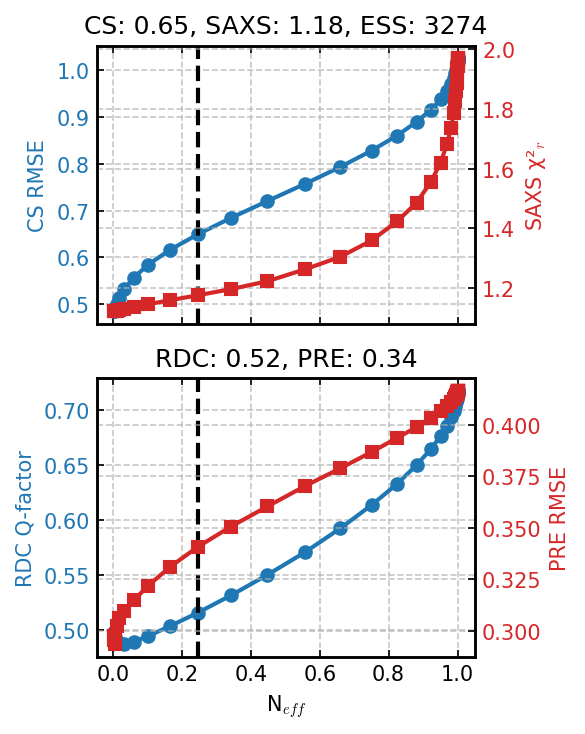

In [7]:
# plot agreement with active and validation data

# Load data
wopt_array = np.load(outpath+'rew_wopt_array.npy')
CS_RMSE = np.loadtxt(outpath+'rew_CS_RMSE.txt')
SAXS_chi2 = np.loadtxt(outpath+'rew_SAXS_chi2r.txt')
RDC_Q = np.loadtxt(outpath+'RDC_Qfactors.txt')
PRE_RMSEs = np.loadtxt(outpath+'PRE_RMSEs.txt')
neffs = np.loadtxt(outpath+'rew_neffs.txt')
ESSs = np.array([np.sum(w)**2/np.sum(w**2) for w in wopt_array])

# Find the last index where neffs > 0.2
idx_opt = np.where(neffs > 0.2)[0][-1]
print(idx_opt)
print(ESSs[idx_opt])

# Create figure with 2 stacked subplots sharing x-axis
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(4, 5), sharex=True)  # taller figure

# ---------------------------
# Top subplot: CS & SAXS
# ---------------------------
ax1.plot(neffs, CS_RMSE, 'o-', label='CS', color='tab:blue')
ax1.set_ylabel('CS RMSE', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(neffs, SAXS_chi2, 's-', label='SAXS', color='tab:red')
ax2.set_ylabel('SAXS χ²$_{r}$', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.axvline(neffs[idx_opt], color='black', linestyle='dashed')
ax1.set_title(f'CS: {CS_RMSE[idx_opt]:.2f}, SAXS: {SAXS_chi2[idx_opt]:.2f}, ESS: {ESSs[idx_opt]:.0f}')

# ---------------------------
# Bottom subplot: RDC & PRE
# ---------------------------
ax3.plot(neffs, RDC_Q, 'o-', label='RDC', color='tab:blue')
ax3.set_xlabel('N$_{eff}$')
ax3.set_ylabel('RDC Q-factor', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')

ax4 = ax3.twinx()
ax4.plot(neffs, PRE_RMSEs, 's-', label='PRE', color='tab:red')
ax4.set_ylabel('PRE RMSE', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

ax3.axvline(neffs[idx_opt], color='black', linestyle='dashed')
ax3.set_title(f'RDC: {RDC_Q[idx_opt]:.2f}, PRE: {PRE_RMSEs[idx_opt]:.2f}')

plt.tight_layout()
plt.savefig(outpath+'BMErew_all_data.pdf')


In [5]:
# ensemble-averaged rg (mass weighted)
protein = 'ACTR_REST2_300K_ensemble'

ntrajs=1
for i in range(ntrajs):
    if i==0:
        rg = np.loadtxt(data_path+f'{protein}/rg_data/rg_traj{i}.txt')
    else:
        tmprg = np.loadtxt(data_path+f'{protein}/rg_data/rg_traj{i}.txt')
        rg = np.concatenate((rg, tmprg), axis=0)

rg_prior = np.average(rg)
rg_posterior = np.average(rg, weights=wopt_array[idx_opt])

wmask = np.where(wopt_array[idx_opt]>0)[0]
rg = rg[wmask]



# errors
reblock_data = pyblock.blocking.reblock(rg)
opt = pyblock.blocking.find_optimal_block(len(rg), reblock_data)[0]
print(opt)
print(len(reblock_data))
err_prior = reblock_data[opt][4]

reblock_data = pyblock.blocking.reblock(rg, weights=wopt_array[idx_opt][wmask])
opt = pyblock.blocking.find_optimal_block(len(rg), reblock_data)[0]
print(opt)
print(len(reblock_data))
err_posterior = reblock_data[opt][4]

# save
df = pd.DataFrame()
df['Ensemble'] = ['prior', 'posterior']
df['Rg (nm)'] = np.round([rg_prior, rg_posterior], decimals=2)
df['±'] = np.round([err_prior, err_posterior], decimals=2)
df.to_csv(outpath+"rg_prior_posterior_massweighted.csv")
df

11
15
8
15


,Ensemble,Rg (nm),±
0,prior,2.05,0.04
1,posterior,2.28,0.03
